In [1]:
from minlsh import MinHashLSHiForest
import data_loader
import numpy as np
from sklearn.metrics import roc_auc_score
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# unswの実験
print("Results of UNSW:")
X_train, y_train, X_test, y_test, y_cat = data_loader.load_unsw_for_minhash()
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")
X_train.head(5)
y_train.head()

Results of UNSW:
X_train size is 56000
X_test size is 82332


0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

In [3]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop - start}")
auc_score = roc_auc_score(y_test, scores)
print(f"AUC Score: {auc_score}")

Trained Time: 0.6283228397369385
Executed Time: 31.428163051605225
AUC Score: 0.7609313837131935


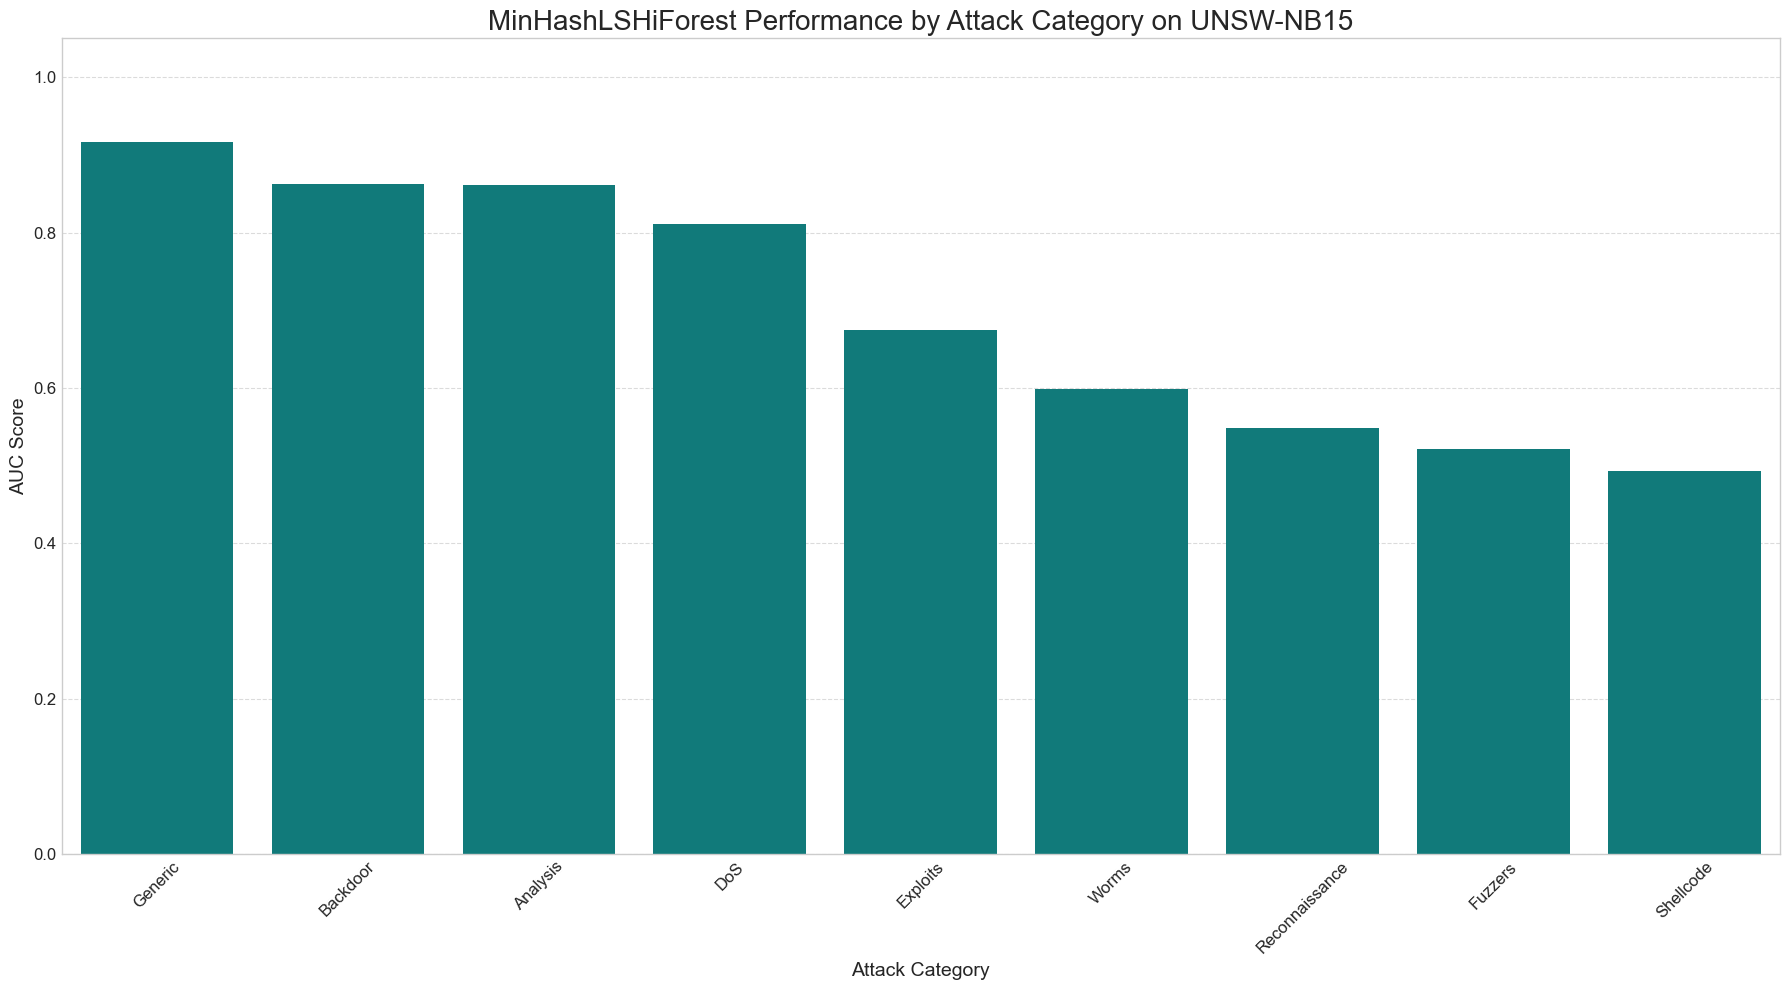

AUC Scores (Each Attack Category vs. Normal Traffic):
  Attack Category  AUC Score
5         Generic   0.916358
1        Backdoor   0.862400
0        Analysis   0.860780
2             DoS   0.810632
3        Exploits   0.674538
8           Worms   0.598410
6  Reconnaissance   0.548709
4         Fuzzers   0.521571
7       Shellcode   0.493172


In [4]:
# 攻撃別手法分析
results_df = pd.DataFrame({
    'attack_cat': y_cat,
    'label': y_test,
    'score': scores 
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# --- 4. グラフの描画 -
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='darkcyan', ax=ax)
ax.set_title('MinHashLSHiForest Performance by Attack Category on UNSW-NB15', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12) 
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df.to_string())

In [5]:
# NSL
X_train, y_train, X_test, y_test = data_loader.load_nsl_for_minhash()
y_true = np.array([0 if label == "normal" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

X_train size is 67343
X_test size is 22544
Trained Time: 0.6583700180053711
Executed Time: 11.713320970535278
AUC Score: 0.9429047954681699


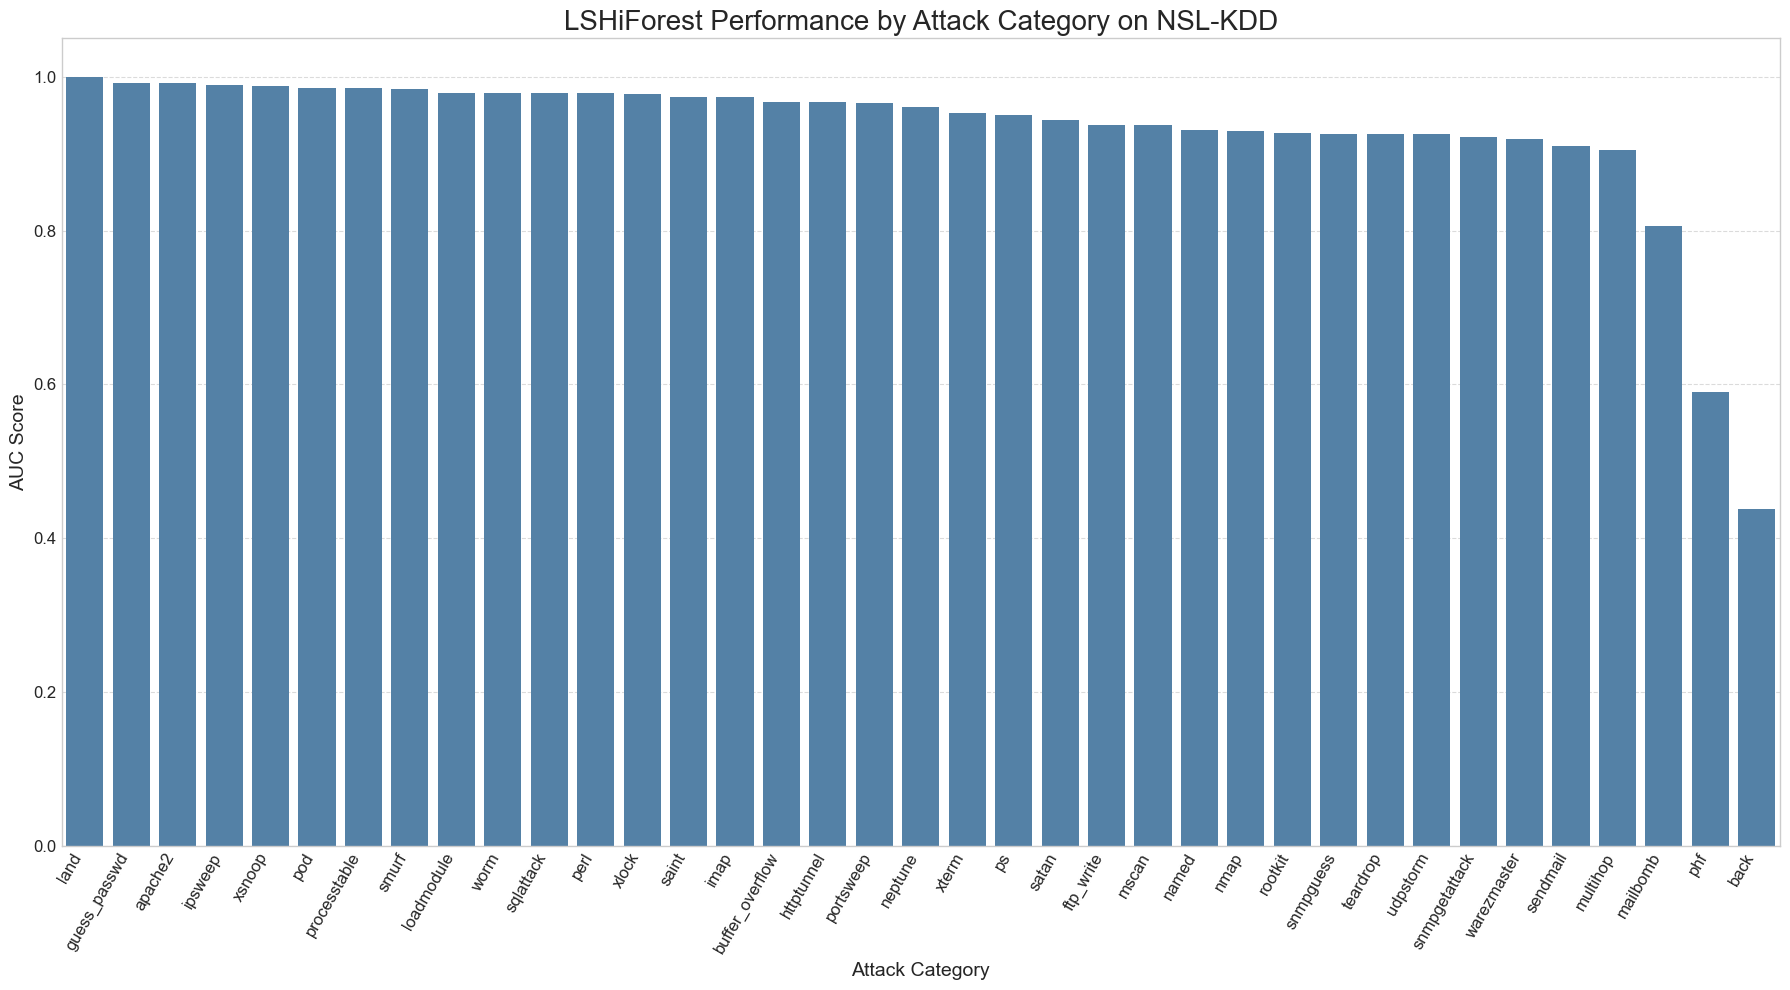

AUC Scores (Each Attack Category vs. Normal Traffic):
    Attack Category  AUC Score
8              land   0.999279
4      guess_passwd   0.991612
0           apache2   0.991478
7           ipsweep   0.989023
35           xsnoop   0.988776
18              pod   0.985457
20     processtable   0.984988
26            smurf   0.984760
9        loadmodule   0.978787
33             worm   0.978787
29        sqlattack   0.978787
16             perl   0.978787
34            xlock   0.977477
23            saint   0.974221
6              imap   0.974153
2   buffer_overflow   0.967300
5        httptunnel   0.967006
19        portsweep   0.966461
14          neptune   0.960593
36            xterm   0.952611
21               ps   0.949885
24            satan   0.943745
3         ftp_write   0.937785
11            mscan   0.937337
13            named   0.930921
15             nmap   0.929042
22          rootkit   0.927101
28        snmpguess   0.925698
30         teardrop   0.925239
31         udpst

In [6]:
# 結果の描写
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'normal' else 1 for label in y_test],
    'score': scores
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)
ax.set_title('LSHiForest Performance by Attack Category on NSL-KDD', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)

In [7]:
# unswでbinningした数値特徴量とカテゴリ値で実験
X_train, y_train, X_test, y_test, y_cat = data_loader.load_unsw_binned()
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")
X_train.head()

X_train size is 56000
X_test size is 82332


0    {sinpkt:0, ct_srv_dst:0, dmean:0, smean:0, dlo...
1    {sinpkt:0, ct_srv_dst:0, smean:0, dloss:0, dby...
2    {sinpkt:0, ct_srv_dst:0, smean:0, dloss:0, dby...
3    {sinpkt:0, ct_srv_dst:0, dmean:0, is_ftp_login...
4    {ct_dst_src_ltm:6, sinpkt:0, dmean:0, stcpb:5,...
dtype: object

In [8]:
# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop - start}")
auc_score = roc_auc_score(y_test, scores)
print(f"AUC Score: {auc_score}")

Trained Time: 2.691883087158203
Executed Time: 326.7710199356079
AUC Score: 0.6865624181712817


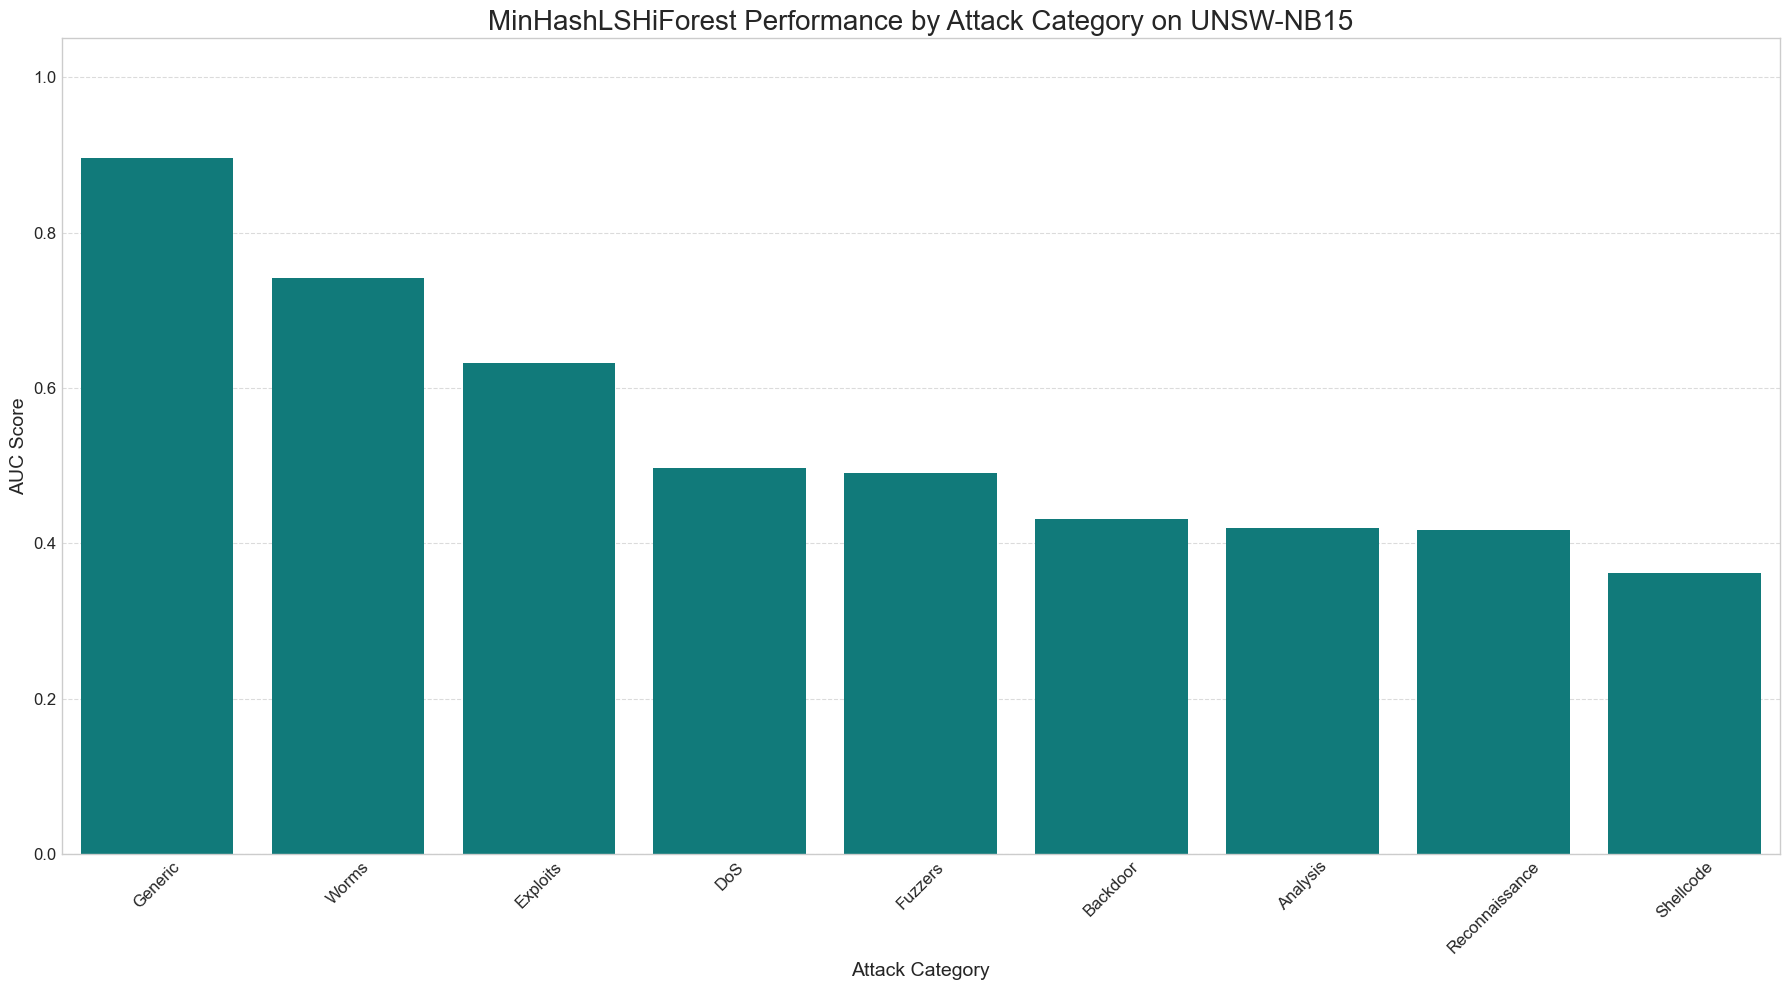

AUC Scores (Each Attack Category vs. Normal Traffic):
  Attack Category  AUC Score
5         Generic   0.895834
8           Worms   0.741290
3        Exploits   0.632261
2             DoS   0.497752
4         Fuzzers   0.491221
1        Backdoor   0.431565
0        Analysis   0.420473
6  Reconnaissance   0.417916
7       Shellcode   0.361455


In [9]:
# 攻撃別手法分析
results_df = pd.DataFrame({
    'attack_cat': y_cat,
    'label': y_test,
    'score': scores  # セル2で計算した異常度スコア
})

# 2. 正常データと攻撃データを分離
normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]

# 3. 各攻撃カテゴリのAUCスコアを計算
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

# --- 4. グラフの描画 -
plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='darkcyan', ax=ax)
ax.set_title('MinHashLSHiForest Performance by Attack Category on UNSW-NB15', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelrotation=45, labelsize=12) # X軸ラベルを回転
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df.to_string())

In [10]:
# NSL
X_train, y_train, X_test, y_test = data_loader.load_nsl_binned()
y_true = np.array([0 if label == "normal" else 1 for label in y_test])
print(f"X_train size is {len(X_train)}")
print(f"X_test size is {len(X_test)}")

# LSHiForestのインスタンス化と学習
lshif = MinHashLSHiForest(n_estimators=100, sample_size=256, eta=1.0)
start = time.time()
lshif.fit(X_train)
stop = time.time()
print(f"Trained Time: {stop -start}")

# 異常スコアの計算
start = time.time()
scores = lshif.decision_function(X_test)
stop = time.time()

# 2. AUCスコアを計算
print(f"Executed Time: {stop-start}")
auc_scores = roc_auc_score(y_true, scores)
print(f"AUC Score: {auc_scores}")

X_train size is 67343
X_test size is 22544
Trained Time: 2.831230878829956
Executed Time: 117.49681520462036
AUC Score: 0.8778766389167473


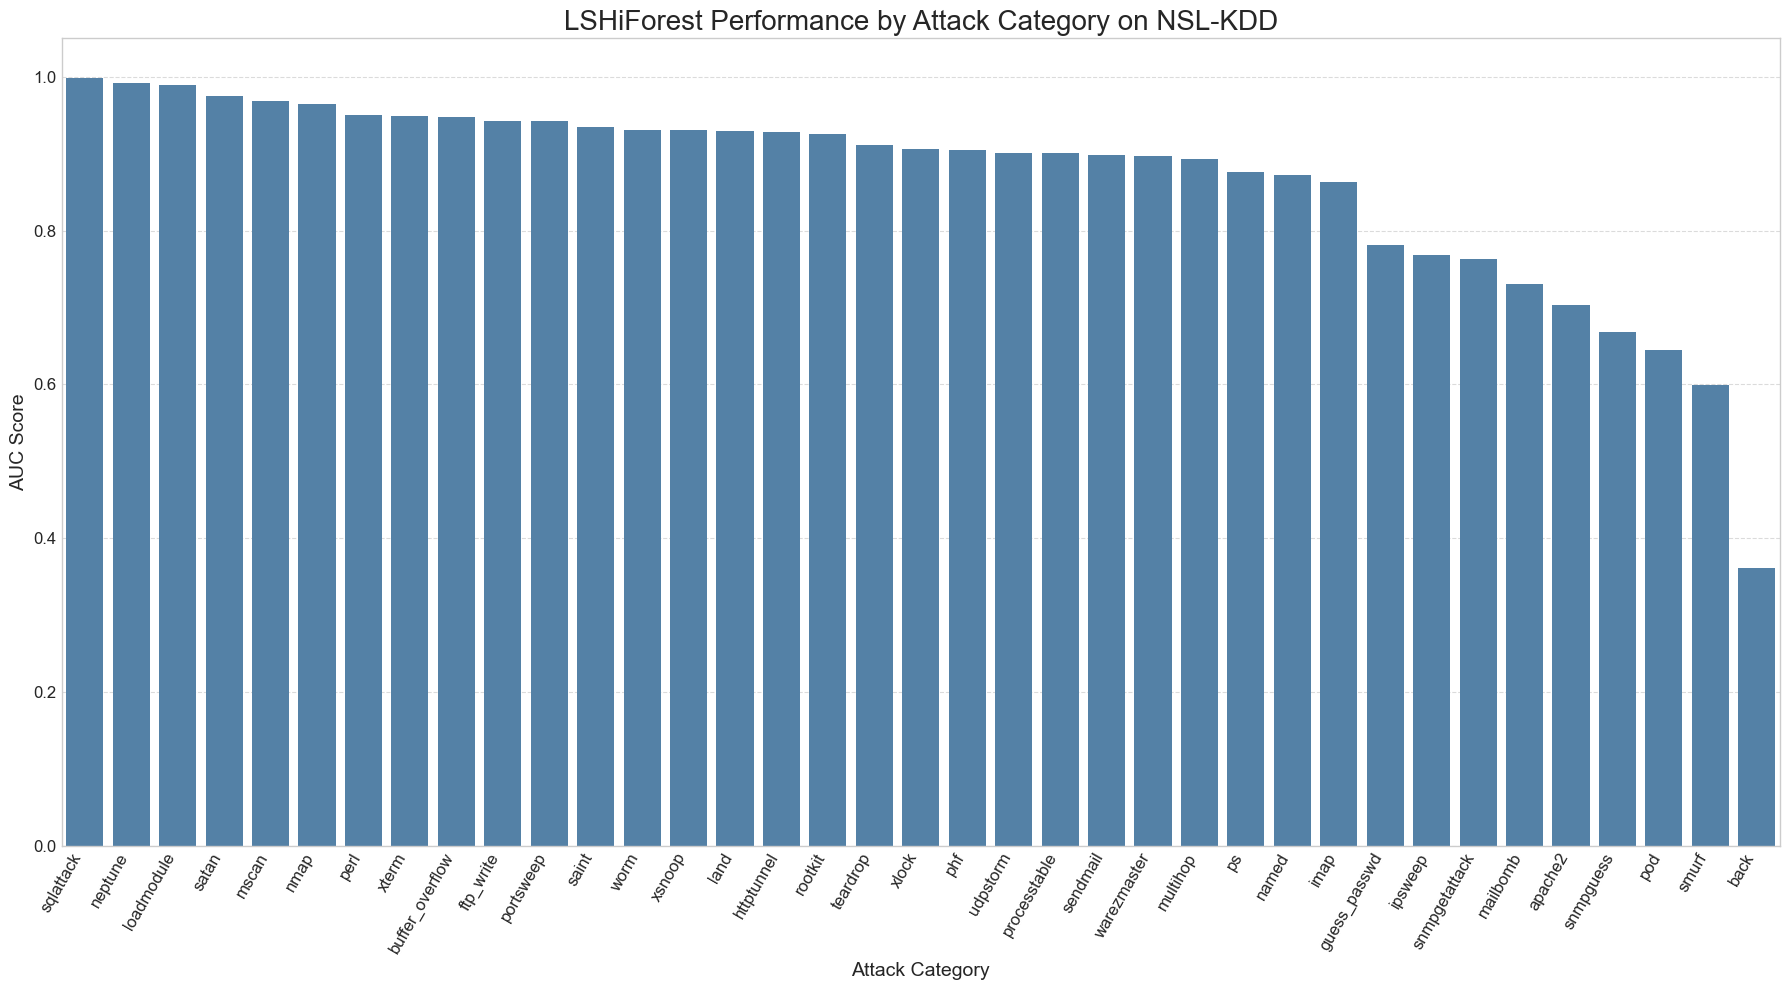

AUC Scores (Each Attack Category vs. Normal Traffic):
    Attack Category  AUC Score
29        sqlattack   0.998146
14          neptune   0.992055
9        loadmodule   0.989496
24            satan   0.975645
11            mscan   0.968871
15             nmap   0.964645
16             perl   0.950983
36            xterm   0.949585
2   buffer_overflow   0.947361
3         ftp_write   0.942780
19        portsweep   0.942566
23            saint   0.934397
33             worm   0.930903
35           xsnoop   0.930414
8              land   0.929741
5        httptunnel   0.928043
22          rootkit   0.925830
30         teardrop   0.911981
34            xlock   0.906681
17              phf   0.904644
31         udpstorm   0.901349
20     processtable   0.901175
25         sendmail   0.897954
32      warezmaster   0.897548
12         multihop   0.893225
21               ps   0.875701
13            named   0.872413
6              imap   0.863763
4      guess_passwd   0.781703
7           ipsw

In [11]:
results_df = pd.DataFrame({
    'attack_cat': y_test,
    'label': [0 if label == 'normal' else 1 for label in y_test],
    'score': scores
})

normal_df = results_df[results_df['label'] == 0]
attack_df = results_df[results_df['label'] == 1]
auc_scores_by_cat = {}
unique_attack_cats = sorted(attack_df['attack_cat'].unique())

for cat in unique_attack_cats:
    current_attack_df = attack_df[attack_df['attack_cat'] == cat]
    eval_df = pd.concat([normal_df, current_attack_df])
    auc = roc_auc_score(eval_df['label'], eval_df['score'])
    auc_scores_by_cat[cat] = auc

plot_df = pd.DataFrame(list(auc_scores_by_cat.items()), columns=['Attack Category', 'AUC Score'])
plot_df = plot_df.sort_values('AUC Score', ascending=False)
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(data=plot_df, x='Attack Category', y='AUC Score', color='steelblue', ax=ax)
ax.set_title('LSHiForest Performance by Attack Category on NSL-KDD', fontsize=20)
ax.set_xlabel('Attack Category', fontsize=14)
ax.set_ylabel('AUC Score', fontsize=14)
ax.set_ylim(0, 1.05)
ax.tick_params(axis='x', labelsize=12) 
plt.setp(ax.get_xticklabels(), rotation=60, ha='right')
ax.tick_params(axis='y', labelsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("AUC Scores (Each Attack Category vs. Normal Traffic):")
print(plot_df)